In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, BatchNormalization, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adam

In [2]:
# Read the dataframe
data = pd.read_csv("Car insurance.csv")
data.head(10)

,id,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,569520,65+,Female,0-9y,high school,upper class,0.629027,Yes,after 2015,No,Yes,10238,12000.0,sedan,0,0,0,No Claim
1,750365,16-25,Male,0-9y,none,poverty,0.357757,No,before 2015,No,No,10238,16000.0,sedan,0,0,0,Claim
2,199901,16-25,Female,0-9y,high school,working class,0.493146,Yes,before 2015,No,No,10238,11000.0,sedan,0,0,0,No Claim
3,478866,16-25,Male,0-9y,university,working class,0.206013,Yes,before 2015,No,Yes,32765,11000.0,sedan,0,0,0,No Claim
4,731664,26-39,Male,10-19y,no education,working class,0.388366,Yes,before 2015,No,No,32765,12000.0,sedan,2,0,1,Claim
5,877557,40-64,Female,20-29y,high school,upper class,0.619127,Yes,after 2015,No,Yes,10238,13000.0,sedan,3,0,3,No Claim
6,930134,65+,Male,30y+,high school,upper class,0.492944,No,after 2015,Yes,Yes,10238,13000.0,sedan,7,0,3,No Claim
7,461006,26-39,Female,0-9y,university,working class,0.468689,No,after 2015,No,Yes,10238,14000.0,sedan,0,0,0,Claim
8,68366,40-64,Female,20-29y,university,working class,0.521815,No,before 2015,Yes,No,10238,13000.0,sedan,0,0,0,No Claim
9,445911,40-64,Female,0-9y,high school,upper class,0.561531,Yes,before 2015,No,Yes,32765,11000.0,sedan,0,0,0,Claim


In [3]:
# Check for duplicates on id
data['id'].duplicated().sum()

0

In [4]:
# Drop this column as it's not needed for analysis
data.drop(columns=['id'], inplace=True)

In [5]:
data.shape

(10000, 17)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  10000 non-null  object 
 1   gender               10000 non-null  object 
 2   driving_experience   10000 non-null  object 
 3   education            10000 non-null  object 
 4   income               10000 non-null  object 
 5   credit_score         9018 non-null   float64
 6   vehicle_ownership    10000 non-null  object 
 7   vehicle_year         10000 non-null  object 
 8   married              10000 non-null  object 
 9   children             10000 non-null  object 
 10  postal_code          10000 non-null  int64  
 11  annual_mileage       9043 non-null   float64
 12  vehicle_type         10000 non-null  object 
 13  speeding_violations  10000 non-null  int64  
 14  duis                 10000 non-null  int64  
 15  past_accidents       10000 non-null  

## Data Cleaning

In [7]:
# Print the different values per column
columns = ['age', 'gender', 'driving_experience', 'education', 'income', 'vehicle_ownership', 'vehicle_year', 'married', 'children', 'postal_code', 'vehicle_type', 'outcome']
for col in columns:
    print(f'\n{data[col].value_counts()}')


26-39    3063
40-64    2931
16-25    2016
65+      1990
Name: age, dtype: int64

Female    5010
Male      4990
Name: gender, dtype: int64

0-9y      3530
10-19y    3299
20-29y    2119
30y+      1052
Name: driving_experience, dtype: int64

high school     4157
university      3928
none             958
no education     957
Name: education, dtype: int64

upper class      4336
middle class     2138
poverty          1814
working class    1712
Name: income, dtype: int64

Yes    6970
No     3030
Name: vehicle_ownership, dtype: int64

before 2015    6967
after 2015     3033
Name: vehicle_year, dtype: int64

No     5018
Yes    4982
Name: married, dtype: int64

Yes    6888
No     3112
Name: children, dtype: int64

10238    6940
32765    2456
92101     484
21217     120
Name: postal_code, dtype: int64

sedan         9523
sports car     477
Name: vehicle_type, dtype: int64

No Claim    6867
Claim       3133
Name: outcome, dtype: int64


In [8]:
# Can merge no education with none
data['education'] = data['education'].replace({'none': 'no education'})
data['education'].value_counts()

high school     4157
university      3928
no education    1915
Name: education, dtype: int64

## Missing Values

In [9]:
# Start imputing missing values
data.isnull().sum()

age                      0
gender                   0
driving_experience       0
education                0
income                   0
credit_score           982
vehicle_ownership        0
vehicle_year             0
married                  0
children                 0
postal_code              0
annual_mileage         957
vehicle_type             0
speeding_violations      0
duis                     0
past_accidents           0
outcome                  0
dtype: int64

In [10]:
# Address the null columns
original_columns = data[['credit_score', 'annual_mileage']]

In [11]:
# Use KNNImputer to impute missing values
columns_to_impute = ['credit_score', 'annual_mileage']
knn = KNNImputer(n_neighbors = 3, weights = 'distance')
data[columns_to_impute] = knn.fit_transform(data[columns_to_impute])

In [12]:
data.isnull().sum()

age                    0
gender                 0
driving_experience     0
education              0
income                 0
credit_score           0
vehicle_ownership      0
vehicle_year           0
married                0
children               0
postal_code            0
annual_mileage         0
vehicle_type           0
speeding_violations    0
duis                   0
past_accidents         0
outcome                0
dtype: int64

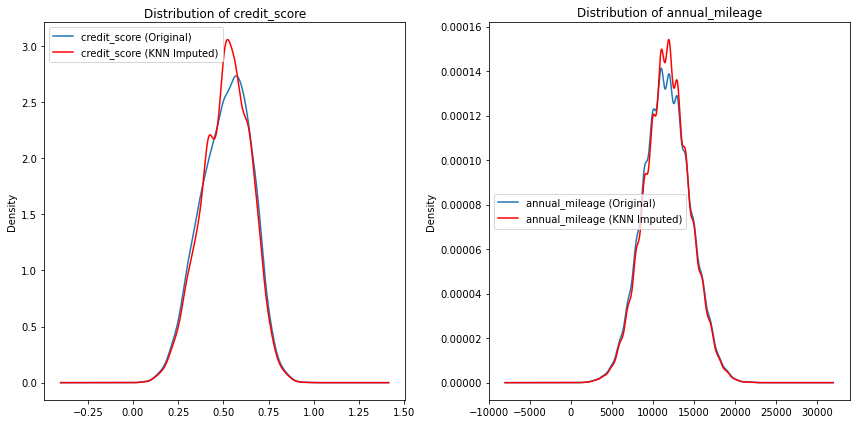

In [13]:
# Create a figure with a grid of subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#plt.figure(figsize = (12, 6))
# Flatten the axes array for easy indexing
axs = axs.flatten()

# Plotting each column in its respective subplot
for i in range(2):
    plt.subplot(1, 2, i+1)
    col = columns_to_impute[i]
    ax = axs[i]
    original_columns[col].plot(kind='kde', ax=ax, label=f'{col} (Original)')
    data[col].plot(kind='kde', ax=ax, color='red', label=f'{col} (KNN Imputed)')
    ax.set_title(f'Distribution of {col}')
    ax.legend(loc='best')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [14]:
# Show the final dataframe
data.head()

,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,65+,Female,0-9y,high school,upper class,0.629027,Yes,after 2015,No,Yes,10238,12000.0,sedan,0,0,0,No Claim
1,16-25,Male,0-9y,no education,poverty,0.357757,No,before 2015,No,No,10238,16000.0,sedan,0,0,0,Claim
2,16-25,Female,0-9y,high school,working class,0.493146,Yes,before 2015,No,No,10238,11000.0,sedan,0,0,0,No Claim
3,16-25,Male,0-9y,university,working class,0.206013,Yes,before 2015,No,Yes,32765,11000.0,sedan,0,0,0,No Claim
4,26-39,Male,10-19y,no education,working class,0.388366,Yes,before 2015,No,No,32765,12000.0,sedan,2,0,1,Claim


## EDA

In [15]:
columns_to_plot = [
    'age', 'gender', 'driving_experience', 'education', 'income',
    'vehicle_ownership', 'vehicle_year', 'married', 'children',
    'postal_code', 'vehicle_type', 'speeding_violations', 'duis',
    'past_accidents', 'outcome'
]

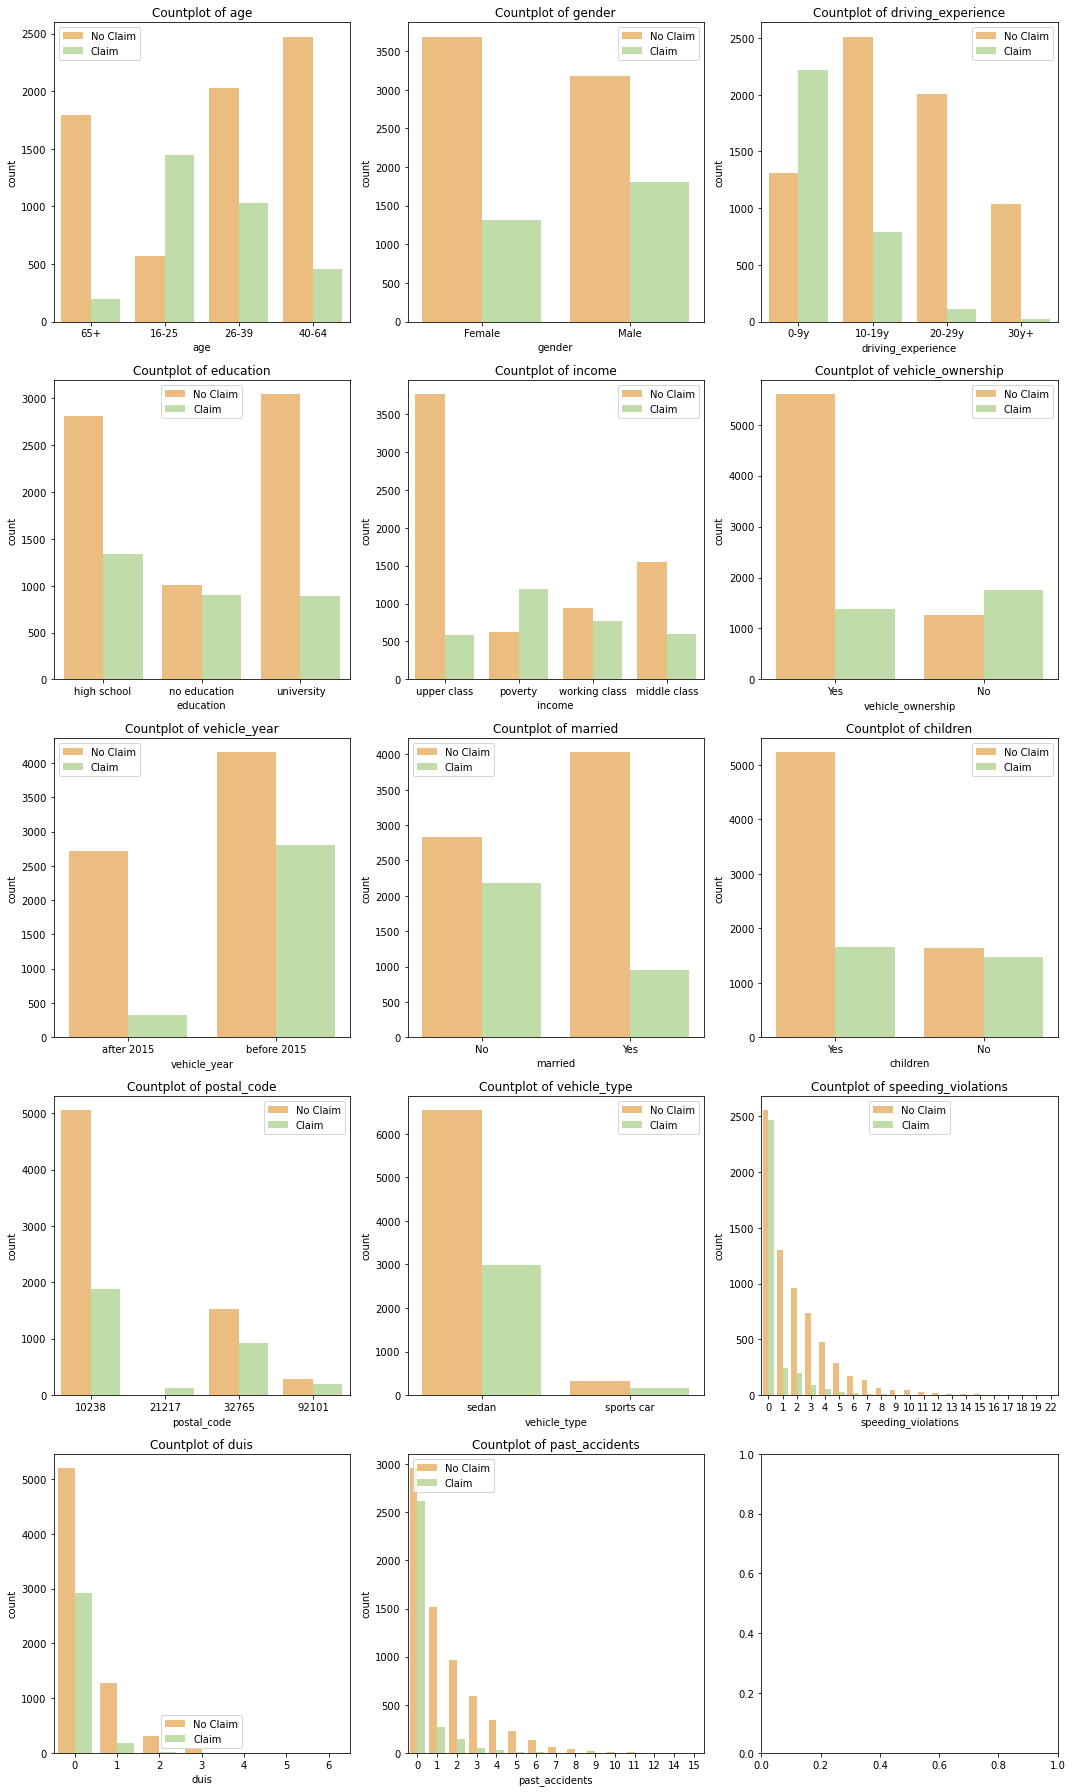

In [16]:
fig, axs = plt.subplots(5, 3, figsize = (15,  25))

# Plotting countplots for each categorical column
for i, col in enumerate(columns_to_plot[:-1]):  # Exclude 'outcome'
    row, col_index = divmod(i, 3)
    ax = axs[row, col_index]
    sns.countplot(x=col, hue='outcome', data=data, ax=ax, palette='Spectral')
    ax.set_title(f'Countplot of {col}')
    ax.legend(loc='best')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

1. AGE
- We can see that the customers in the age group of 40-64 have the highest ratio who have not claimed the insurance uptill now. While the age group 16-24 have the highest ratio who claimed the innsurance money. This means hat age is someho related to insurance claim.

2. GENDER
- In both genders, we have greater number of customers who have claimed the insurance. So we can conclude that the customers gender have no effect on the insurance claim.

3. DRIVING EXPERIENCE
- In this column we can see that the people who have a exoereince of 30+ years have never claimed any insurance. This may be due to the fact that there experince saves them from accidents and traffic rules violation.

4. VEHICLE YEAR
- Cars bought after 2015 have low count for insurance claims, while the cars bought before 2015 have higher ratio of claims.

5. INCOME
- In the income column we can see that the rich class has the highest ratio of customers who have not claimed the insurance money.

6. SPEEDING VIOLATIONS, DUIS AND PAST ACCIDENTS
- In these columns we can see that as the values increase the claim decrease, and similarly the customers who have not claimed also decresed

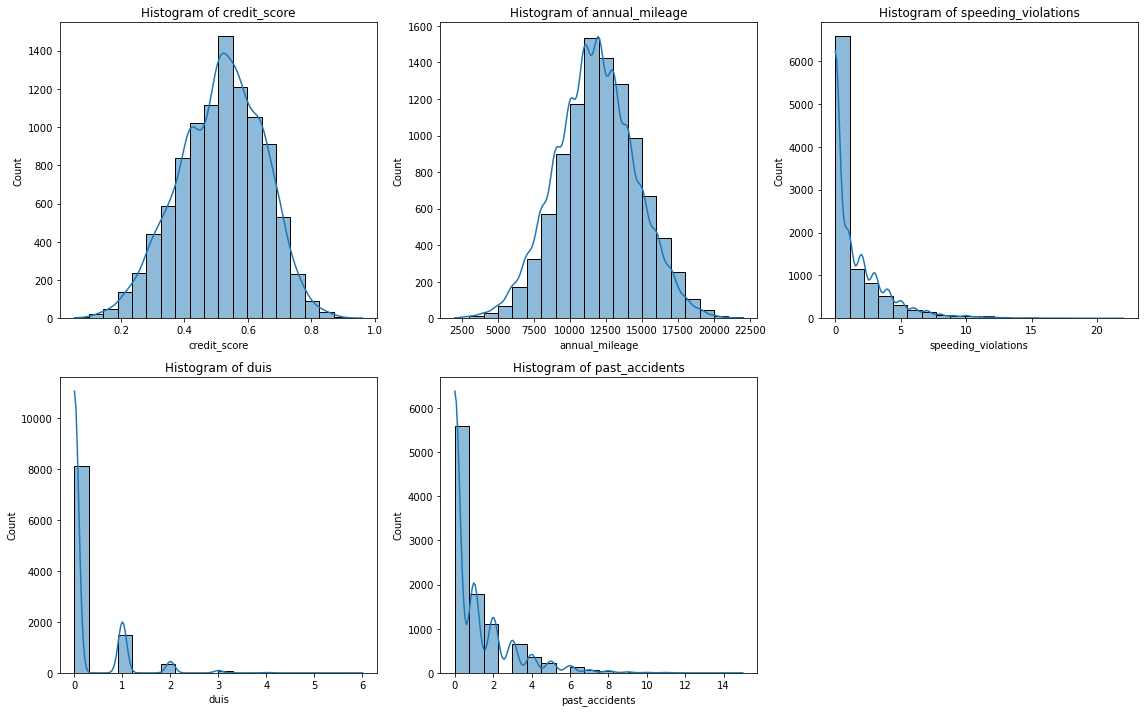

In [17]:
# List of numerical columns
columns = ['credit_score', 'annual_mileage', 'speeding_violations', 'duis', 'past_accidents']

plt.figure(figsize=(16, 10))

# Create histograms for each numerical column
for i, column in enumerate(columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data[column], bins = 20, kde = True)
    plt.xlabel(column)
    plt.title(f'Histogram of {column}')
    
plt.tight_layout()
plt.show()

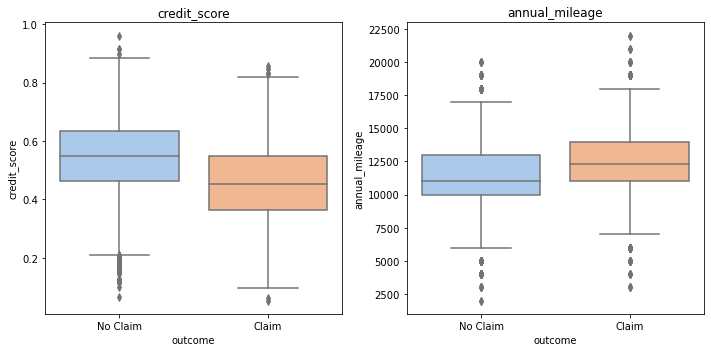

In [18]:
# Interquartile range and outliers

columns = ['credit_score', 'annual_mileage']
fig, axs = plt.subplots(1, 2, figsize = (15,  5))

for i, col in enumerate(columns):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(x='outcome', y=col, data=data, palette='pastel')
    plt.title(f'{col}')

plt.tight_layout()
plt.show()

1. Credit Score
- Median of 'No Claim' is higher than the 'Claim' 
- Those with a higher credit score are less likely to put in a claim
- Box plot is wider for 'Claim' indicating more variability in credit scores

2. Annual Mileage
- The 'Claim' and 'No Claim' average are almost equal here - those who drive more are slightly more likely to file a claim
- The IQR are similar also, suggesting that claims filed do not differ much in terms of annual mileage
- High outliers for 'No Claim' - customers with very high annual mileages never filed a complaint

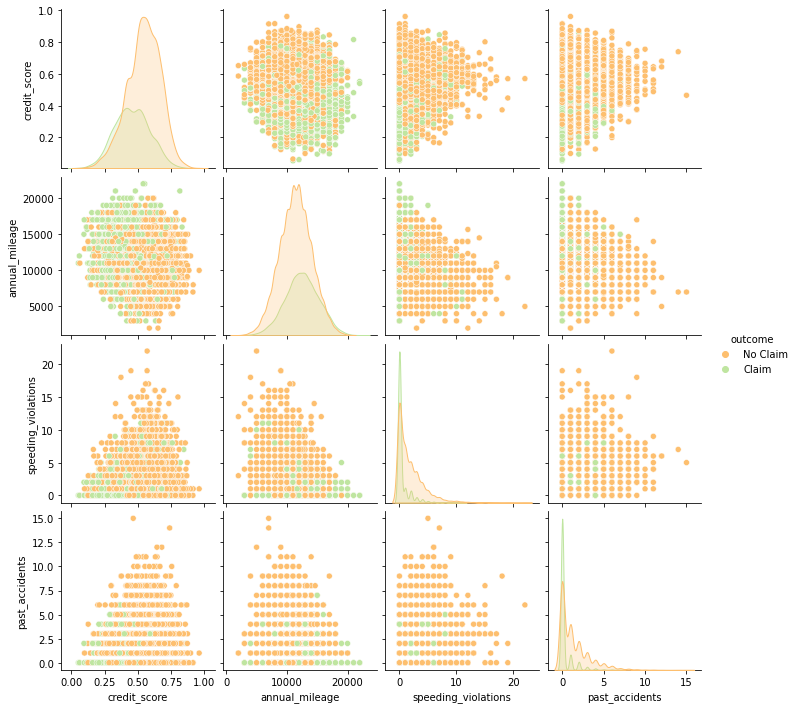

In [19]:
sns.pairplot(data[['credit_score', 'annual_mileage', 'outcome', 'speeding_violations', 
                 'past_accidents']], hue = 'outcome', palette = 'Spectral')
plt.show()

## Hypothesis Tests

#### Hypothesis 1: Drivers with 30+ years experience have made less claims that others
- **Null Hypothesis (H0):** There is no significant association
- **Alternative Hypothesis (H1):** People with 30+ years experience have fewer claims

In [20]:
# Get the numeric outcome column
X = data['outcome'].apply(lambda x: 1 if x == 'Claim' else 0)

# Get the filtered column for driving expreince
Y = data['driving_experience'].apply(lambda x: '30+ years' if '30' in x else 'Less than 30 years')

In [21]:
# Create a table for the above two columns
table = pd.crosstab(X, Y)
table

driving_experience,30+ years,Less than 30 years
outcome,,
0,1032,5835
1,20,3113


In [22]:
# Perform Chi square test
chi2, p_value, dof, expected = stats.chi2_contingency(table)
chi2, p_value, dof, expected

(471.74276454002126,
 1.338233477953956e-104,
 1,
 array([[ 722.4084, 6144.5916],
        [ 329.5916, 2803.4084]]))

- We can see that the p_value < 0.05 so we: 
  
  **Reject the null hypothesis**
   - People with 30+ years experience have fewer claims

#### Hypothesis 2: Drivers with less than 2 accidents have made less claims than those with more
- **Null Hypothesis (H0):** There is no significant association
- **Alternative Hypothesis (H1):** Significant association between people with fewer than 2 accidents and not making an insurance claim

In [23]:
Y =  data['past_accidents'].apply(lambda x: 'Fewer than 2' if x < 2 else 'More than 2')

In [24]:
table = pd.crosstab(X,Y)
table

past_accidents,Fewer than 2,More than 2
outcome,,
0,4476,2391
1,2891,242


In [25]:
# Perform the Chi-square test
chi2_stat, p_value, dof, expected = stats.chi2_contingency(table)
chi2_stat, p_value, dof, expected

(812.8341626290464,
 8.744010251267522e-179,
 1,
 array([[5058.9189, 1808.0811],
        [2308.0811,  824.9189]]))

- We can see that the p_value < 0.05 so we: 
  
  **Reject the null hypothesis**
  - There is a significant association between having fewer than 2 accidents and making an insurance claim

#### Hypothesis 3: Lower income people make more insurance claims
- **Null Hypothesis (H0):** There is no significant association
- **Alternative Hypothesis (H1):** Significant association between lower income people and number of insurance claims made

In [26]:
Y = data['income'].apply(lambda x: 'Lower income' if x == 'poverty' else 'High Income')

In [27]:
table = pd.crosstab(X, Y)
table

income,High Income,Lower income
outcome,,
0,6239,628
1,1947,1186


In [28]:
# Perform the Chi-square test
chi2_stat, p_value, dof, expected = stats.chi2_contingency(table)
chi2_stat, p_value, dof, expected

(1192.2806544286773,
 2.903573132064946e-261,
 1,
 array([[5621.3262, 1245.6738],
        [2564.6738,  568.3262]]))

- We can see that the p_value < 0.05 so we: 
  
  **Reject the null hypothesis**
  - There is a significant association between having a lower income level and making an insurance claim

## Feature Transformation

**Feature Engineering**
  - Scaling Numerical Data
  - Encoding Categorical Variables
  - Dimensionality Reduction of DataFrame

### 1. Data Scaling
- Box plot showed that we already have outliers in the data
- Will use Robust Scaler to combat the outliers (more robust to the outliers)

In [29]:
data.head()

,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,65+,Female,0-9y,high school,upper class,0.629027,Yes,after 2015,No,Yes,10238,12000.0,sedan,0,0,0,No Claim
1,16-25,Male,0-9y,no education,poverty,0.357757,No,before 2015,No,No,10238,16000.0,sedan,0,0,0,Claim
2,16-25,Female,0-9y,high school,working class,0.493146,Yes,before 2015,No,No,10238,11000.0,sedan,0,0,0,No Claim
3,16-25,Male,0-9y,university,working class,0.206013,Yes,before 2015,No,Yes,32765,11000.0,sedan,0,0,0,No Claim
4,26-39,Male,10-19y,no education,working class,0.388366,Yes,before 2015,No,No,32765,12000.0,sedan,2,0,1,Claim


In [30]:
numerical_columns = ['credit_score', 'annual_mileage', 'speeding_violations', 
                 'duis', 'past_accidents']

In [31]:
# Feature Scaling
scaler = RobustScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

### 2. Encoding Categorical Columns
- Will use Label Encoder to transform the categorical variables

In [32]:
columns_to_encode = [
    'age', 'gender', 'driving_experience', 'education', 'income',
    'vehicle_ownership', 'vehicle_year', 'married', 'children',
    'postal_code', 'vehicle_type', 'speeding_violations', 'duis',
    'past_accidents', 'outcome'
]

In [33]:
# Encode categorical variables
label_encoders = {}
for column in columns_to_encode:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

In [34]:
data.head()

,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,3,0,0,0,2,0.561777,1,0,0,1,0,0.00,0,0,0,0,1
1,0,1,0,1,1,-0.847305,0,1,0,0,0,1.00,0,0,0,0,0
2,0,0,0,0,3,-0.144044,1,1,0,0,0,-0.25,0,0,0,0,1
3,0,1,0,2,3,-1.635523,1,1,0,1,2,-0.25,0,0,0,0,1
4,1,1,1,1,3,-0.688311,1,1,0,0,2,0.00,0,2,0,1,0


### 3. Feature Correlation

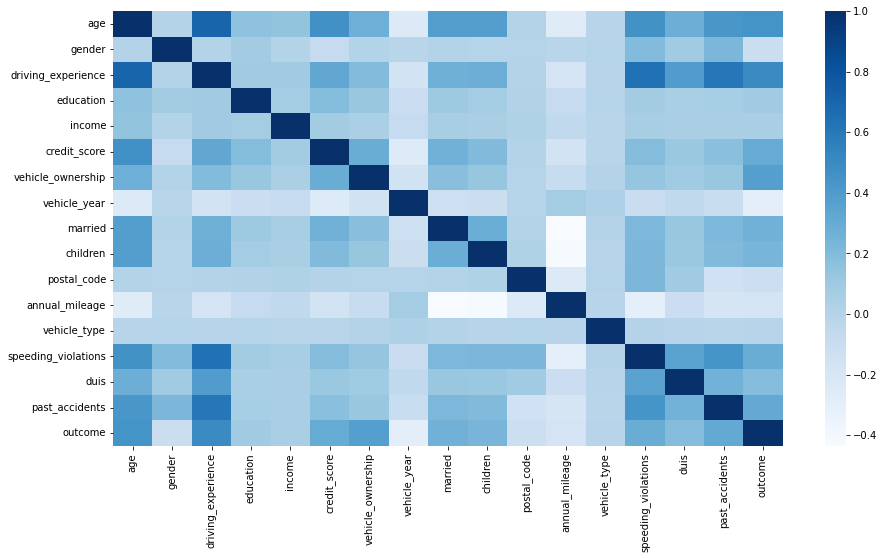

In [35]:
# Correlation matrix
plt.figure(figsize=(15, 8))
sns.heatmap(data.corr(), annot=False, cmap = 'Blues')
plt.show()

**Strong Correlations:**
1. *Driving experience and age:* 
- A strong positive correlation is expected because older people usually have more driving experience.
2. *Vehicle year and vehicle ownership:* 
- They have a mild positive correlation, implying that leasing or financing are less common in newer cars.
3. *Annual mileage and vehicle type:* 
- It means there is a mild positive correlation showing that some types of vehicles might be associated with higher miles driven per year.

**Negative Correlations:**
1. *Past accidents and driving experience:* 
- This suggests a negative relationship between the two variables since experienced drivers tend to have few past accidents.
2. *Vehicle year and past accidents:* 
- There appears to be a very slight negative relationship suggesting that newer vehicles may have fewer past accidents.
3. *Income and duis (driving under influence):* 
- This indicates a negative relationship where those with higher incomes may possess fewer DUIs.

**Outcome Variable:**
The outcome variable, which represents insurance claims, has varying correlations with other features:
- *Negative correlations:* 
    - These indicate less insurance claims as suggested by its association with prior collisions, speeding tickets and duis.
- *Positive correlations:* 
    - These include more insurance claims such as seen when looking at credit score and income.

### 4. Dimensionality Reduction
- The correlation matrix shows that there are some features that do not have a strong impact on the target variable. Including these features in the model development can make our work harder and will increase the complexity of our model and may also affect performance.
- A good pratice can be to reduce the dimensionality of our data and only keep the data that give us the maximum variance for the outcome varibale
- For this we can use Principal Component Analysis on our data.
- We will first fit the model on the our data and get the best number of features for our data. Then we will use those reduced features to train our model.

In [36]:
# Fit PCA
pca = PCA()
pca.fit(data.drop(columns = 'outcome'))

PCA()

In [37]:
# View explained variance ratio
explained_variances = pca.explained_variance_ratio_
print(explained_variances)

[0.46575794 0.14159468 0.07875357 0.06077062 0.05578078 0.05025368
 0.03184991 0.0225653  0.01756213 0.0165603  0.0127597  0.01180389
 0.01102832 0.01087437 0.00907072 0.00301412]


In [38]:
cumulative_explained_variances = explained_variances.cumsum()
print(cumulative_explained_variances)

[0.46575794 0.60735262 0.68610619 0.7468768  0.80265758 0.85291126
 0.88476116 0.90732646 0.92488859 0.94144889 0.95420858 0.96601247
 0.97704079 0.98791516 0.99698588 1.        ]


- After calculating the cumulative_explained_variances we can get a better idea for our data.
- We can see that at the index 7 we have a value of 0.9073 which means that first 8 principal components together explain 90% of the variance in the dataset.
- This means that 8 components will be the best dimension fo rour data. We can get a better idea of the dimension by plotting the cumulative_explained_variances vs the number of components.

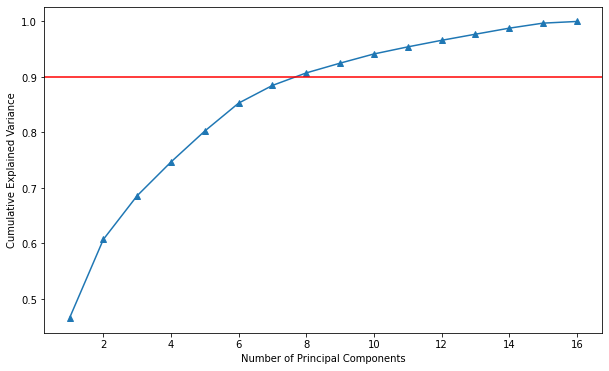

In [39]:
# Plot cumulative explained variance
plt.figure(figsize = (10, 6))
plt.plot(range(1, 17), cumulative_explained_variances, marker = '^')
plt.axhline(y = 0.90, color='r')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

- The above model proves our previous claim that 8 componenets are best for our model. Now we will fit PCA on 8 components.

In [40]:
# Dimensionality Reduction (PCA)
pca = PCA(n_components = 8)
X_pca = pca.fit_transform(data.drop(columns = ['outcome']))

In [41]:
# Reduce the dimensionality from 17 to 8
X_pca.shape

(10000, 8)

## Train-Test Split

In [42]:
X = X_pca
y = data['outcome']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 8), (2000, 8), (8000,), (2000,))

# Model Development

#### Baseline Models 
- Let's develop different ML models for the insurance claim forecast objective
- Use common/popular classifiers here: 
    - **Logistic Regression**
    - **Support Vector Classifier**
    - **Random Forest Classifier**
    - **Decision Tree Classifier**
    
- More advanced mathematical tools will be introduced to test the benchmark of the above models and stress the accuracy of the forecast:
    - **Artificial Neural Networks**
    - **Convolutional Neural Networks**
- Both models are good at capturing complex patterns and interactions within the data

In [44]:
# Apply random oversampling to handle class imbalance
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

### 1. Logistic Regression

              precision    recall  f1-score   support

           0       0.61      0.77      0.68       633
           1       0.88      0.77      0.82      1367

    accuracy                           0.77      2000
   macro avg       0.74      0.77      0.75      2000
weighted avg       0.79      0.77      0.77      2000

Accuracy is: 0.7685



<Figure size 864x648 with 0 Axes>

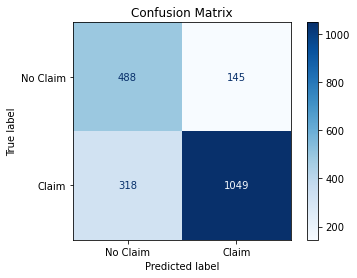

In [45]:
model = LogisticRegression(class_weight = 'balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
    
# Print the classification report and confusion matrix
print(classification_report(y_test, y_pred))    

accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy is: {accuracy}\n')

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 9))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['No Claim', 'Claim']).plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

- Claim precision and recall are higher in comparison to No Claim
- Model performs better to identifying claims

*No Claim (0):*
- Precision: 0.61 — When the model predicts "No Claim," 61% of the time it's correct.
- Recall: 0.77 — Of all the actual "No Claim" cases, the model correctly identified 77%.
- F1-Score: 0.68 — A harmonic mean of precision and recall, showing overall balance for this class.

*Claim (1):*
- Precision: 0.88 — When the model predicts "Claim," it’s correct 88% of the time.
- Recall: 0.77 — The model identified 77% of actual "Claim" cases.
- F1-Score: 0.82 — Good balance between precision and recall.

In [46]:
# Implement Grid Search hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],    
    'solver': ['liblinear', 'saga'] }

grid_search = GridSearchCV(estimator = LogisticRegression(class_weight = 'balanced'), param_grid = param_grid)

grid_search.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']})

In [47]:
# Get the best model from the GridSearchCV tuning
best_model = grid_search.best_estimator_

#Make predictions with the best model
y_pred = best_model.predict(X_test)

Logistic Regression after Hyper Parameter Tuning Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.77      0.68       633
           1       0.88      0.77      0.82      1367

    accuracy                           0.77      2000
   macro avg       0.74      0.77      0.75      2000
weighted avg       0.79      0.77      0.77      2000

Accuracy: 0.767



<Figure size 864x648 with 0 Axes>

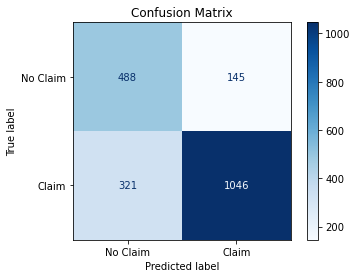

In [48]:
print(f'Logistic Regression after Hyper Parameter Tuning Classification Report:\n', classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}\n')

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize =(12, 9))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['No Claim', 'Claim']).plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

*No Claim (0):*
- Precision: 0.60 (slightly lower than 0.61 previously)
- Recall: 0.77 (unchanged)
- F1-Score: 0.68 (unchanged)

*Claim (1):*
- Precision: 0.88 (unchanged)
- Recall: 0.77 (unchanged)
- F1-Score: 0.82 (unchanged)


- The hyperparameter tuning with GridSearchCV has returned almost identical, if not lower scores than the previous prediction model (Accuracy of 76.7% < 76.85%)

### 2. Support Vector Classifier

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.80      0.68       633
           1       0.89      0.75      0.81      1367

    accuracy                           0.76      2000
   macro avg       0.74      0.77      0.75      2000
weighted avg       0.80      0.76      0.77      2000

Accuracy: 0.764


<Figure size 864x648 with 0 Axes>

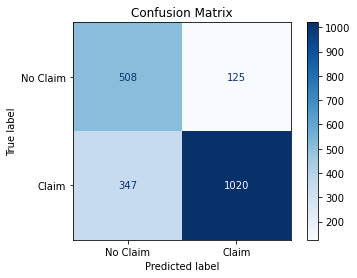

In [49]:
model = SVC(class_weight = 'balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
    
report = classification_report(y_test, y_pred)
# Print the classification report and confusion matrix
print(f'Classification Report:\n', classification_report(y_test, y_pred))    

accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 9))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['No Claim', 'Claim']).plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

- Support Vector Classifier returned an accuracy of 76.4%
- The true negative rate is high (predicted as No Claim, actual label is Claim)

### 3. Decision Tree Classifier

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.57      0.57       633
           1       0.80      0.81      0.80      1367

    accuracy                           0.73      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.73      0.73      0.73      2000

Accuracy: 0.732


<Figure size 864x648 with 0 Axes>

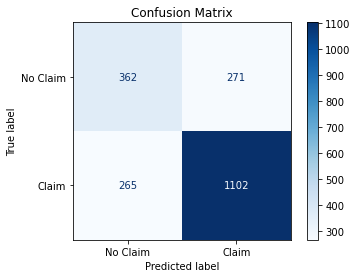

In [50]:
model = DecisionTreeClassifier(class_weight = 'balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
    
report = classification_report(y_test, y_pred)
# Print the classification report and confusion matrix
print(f'Classification Report:\n', classification_report(y_test, y_pred))    

accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 9))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['No Claim', 'Claim']).plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

- The Decision Tree Classifier returned an accuracy of 72.8%
- Higher accuracy in predicting Claims (F1-Score of 0.80 vs 0.57)
- Lower overall accuracy score compared to SVC 

## Artificial Neural Network

*Define the Model:*
1. **Input Layer:** `Dense(28, activation='relu', input_shape=(X_train.shape[1],)):` A dense (fully connected) layer with 28 neurons and ReLU activation function.
2. **Batch Normalization Layer:** `BatchNormalization():` This layer normalizes the output of the previous layer, which helps in stabilizing and speeding up the training process by reducing internal covariate shift.
3. **Dropout Layer:** `Dropout(0.3):` This helps in preventing overfitting by randomly setting 30% of the neurons in the previous layer to zero during each update.
4. **Output Layer:** `Dense(1, activation='sigmoid'):` A dense layer with a single neuron and a sigmoid activation function. This layer is responsible for outputting the probability of the binary classification task.

In [51]:
ann_model = Sequential([
    # Input Layer
    Dense(28, activation='relu', input_shape = (X_train.shape[1],)), 
    BatchNormalization(),
    # Drop out to avoid overfitting
    Dropout(0.3),
    # Output Layer
    Dense(1, activation='sigmoid')
])

*Compile the Model:*
1. **Optimizer:** `Adam(learning_rate=0.0006):` The Adam optimizer is used with a learning rate of 0.0006, which adjusts the weights based on the gradients during backpropagation.
2. **Loss Function:** `binary_crossentropy:` The binary cross-entropy loss function is used for binary classification problems, measuring the difference between predicted probabilities and actual class labels.
3. **Metrics:** `accuracy:` Accuracy is used as a metric to evaluate the model's performance during training and validation.

In [52]:
# Compile the model with an optimizer, loss function, and metric
ann_model.compile(optimizer = Adam(learning_rate=0.0006), loss = 'binary_crossentropy', metrics = ['accuracy'])

*Fit the Model:*
- The model is trained using 200 epochs with a batch size of 32. The model performance is validate by test set.

In [53]:
history = ann_model.fit(X_train, y_train, epochs = 200,  batch_size = 32, validation_data = (X_test, y_test))

Epoch 1/200
250/250 [==============================] - 4s 8ms/step - loss: 0.5870 - accuracy: 0.7003 - val_loss: 0.4662 - val_accuracy: 0.7920
Epoch 2/200
250/250 [==============================] - 1s 4ms/step - loss: 0.4937 - accuracy: 0.7664 - val_loss: 0.4459 - val_accuracy: 0.7960
Epoch 3/200
250/250 [==============================] - 1s 5ms/step - loss: 0.4711 - accuracy: 0.7815 - val_loss: 0.4405 - val_accuracy: 0.7980
Epoch 4/200
250/250 [==============================] - 1s 4ms/step - loss: 0.4682 - accuracy: 0.7820 - val_loss: 0.4390 - val_accuracy: 0.7965
Epoch 5/200
250/250 [==============================] - 1s 4ms/step - loss: 0.4630 - accuracy: 0.7790 - val_loss: 0.4371 - val_accuracy: 0.7965
Epoch 6/200
250/250 [==============================] - 1s 6ms/step - loss: 0.4636 - accuracy: 0.7812 - val_loss: 0.4369 - val_accuracy: 0.7935
Epoch 7/200
250/250 [==============================] - 1s 4ms/step - loss: 0.4589 - accuracy: 0.7809 - val_loss: 0.4357 - val_accuracy: 0.7990

In [54]:
# Evaluate the model
loss, accuracy = ann_model.evaluate(X_test, y_test)
loss, accuracy

63/63 [==============================] - 0s 3ms/step - loss: 0.4267 - accuracy: 0.8005


(0.4267171025276184, 0.8004999756813049)

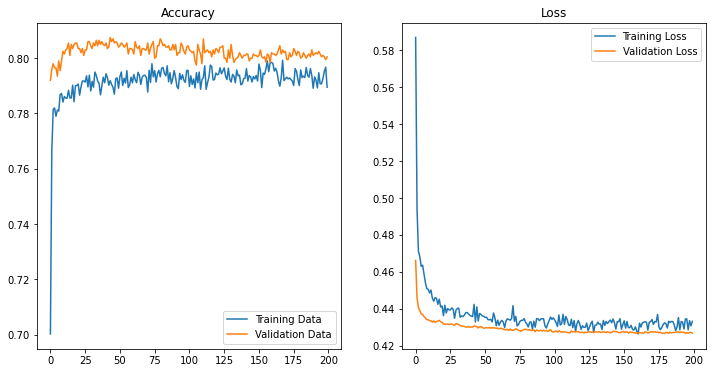

In [55]:
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Data')
plt.plot(history.history['val_accuracy'], label='Validation Data')
plt.title('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

The plot shows that our model has performed quite well.

**Accuracy:**
- The left graph shows the accuracy of the model on both the training and validation datasets. The blue line represents the training accuracy, starting just above 0.625 and gradually increasing to just below 0.80. The orange line represents the validation accuracy, starting around 0.75 and ending around 0.80. Both lines fluctuate but show an overall upward trend, indicating that the model is learning and improving its accuracy over time.

**Loss:**
- The right graph depicts the loss values for both the training and validation datasets. The blue line indicates the training loss, which starts above 0.70 and decreases to close to 0.45. The orange line shows the validation loss, beginning around 0.50 and dropping sharply to just above 0.50 before flattening out. This downward trend in loss values suggests that the model is effectively minimizing errors during training.

In [56]:
# Predict the labels for the test set
y_pred = (ann_model.predict(X_test) > 0.5).astype("int32")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the Accuracy and Loss Curves
plt.figure(figsize=(12, 6))

63/63 [==============================] - 0s 2ms/step


<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x648 with 0 Axes>

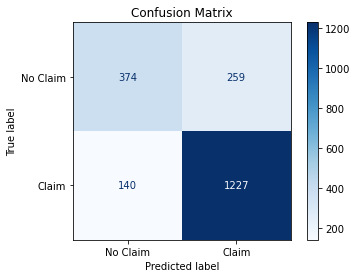

In [57]:
# Plot confusion matrix
plt.figure(figsize=(12, 9))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Claim', 'Claim']).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

- True Positives: 1,227
- True Negatives: 374
- False Positives: 259
- False Negatives: 140

## Convolutional Neural Network

In [58]:
# 1D Convolutional Model
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

*Define the Model:*
1. **Input Layer & Convolutional Block 1:**
    - `Conv1D` Layer: The first layer applies 32 convolutional filters, each with a size of 2, to the input data. The activation function used is ReLU ('relu'), which helps introduce non-linearity. The 'same' padding ensures that the output has the same length as the input.
    - `Input Shape:` The input shape is defined as (X_train_cnn.shape[1], 1), where X_train_cnn.shape[1] represents the number of features in the input data, and 1 represents a single channel.
    - `MaxPooling1D Layer:` This layer reduces the spatial size of the representation to decrease the computational cost and control overfitting. The pooling size is set to 2, which reduces the dimensionality by a factor of 2.

2. **Flatten Layer:** This layer flattens the 1D output from the convolutional layers into a 1D vector, preparing it for the fully connected layers.

3. **Fully Connected Layers:** `Dense Layer (24 units):` This layer has 24 neurons with ReLU activation, which further processes the flattened data.

4. **Dropout Layer (0.5):** Dropout is applied to reduce overfitting by randomly setting 50% of the input units to zero during training.

5. **Output Layer:** The final dense layer has 1 neuron with a sigmoid activation function, which outputs a probability for binary classification.

In [59]:
cnn_model = Sequential()

# Block 1
cnn_model.add(Conv1D(32, 2, activation='relu', padding='same', input_shape=(X_train_cnn.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=2))

cnn_model.add(Flatten())

cnn_model.add(Dense(24, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid'))

*Compile the Model:*
- Compiled using the Adam optimizer which adapts the learning rate during training
- Loss function used is binary_crossentropy (appropriate for binary classification tasks)

In [60]:
# Compile the model
cnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [61]:
# Train the model
history = cnn_model.fit(X_train_cnn, y_train, validation_data = (X_test_cnn, y_test), epochs = 100, batch_size = 32)

Epoch 1/100
250/250 [==============================] - 3s 5ms/step - loss: 0.5332 - accuracy: 0.7352 - val_loss: 0.4674 - val_accuracy: 0.7935
Epoch 2/100
250/250 [==============================] - 1s 4ms/step - loss: 0.4771 - accuracy: 0.7771 - val_loss: 0.4506 - val_accuracy: 0.7950
Epoch 3/100
250/250 [==============================] - 1s 5ms/step - loss: 0.4645 - accuracy: 0.7816 - val_loss: 0.4447 - val_accuracy: 0.7975
Epoch 4/100
250/250 [==============================] - 1s 6ms/step - loss: 0.4523 - accuracy: 0.7860 - val_loss: 0.4456 - val_accuracy: 0.8005
Epoch 5/100
250/250 [==============================] - 1s 5ms/step - loss: 0.4529 - accuracy: 0.7904 - val_loss: 0.4383 - val_accuracy: 0.7985
Epoch 6/100
250/250 [==============================] - 2s 7ms/step - loss: 0.4506 - accuracy: 0.7890 - val_loss: 0.4395 - val_accuracy: 0.8000
Epoch 7/100
250/250 [==============================] - 2s 6ms/step - loss: 0.4528 - accuracy: 0.7853 - val_loss: 0.4369 - val_accuracy: 0.7950

In [62]:
# Evaluate the model
loss, accuracy = cnn_model.evaluate(X_test_cnn, y_test)

63/63 [==============================] - 0s 3ms/step - loss: 0.4423 - accuracy: 0.8020


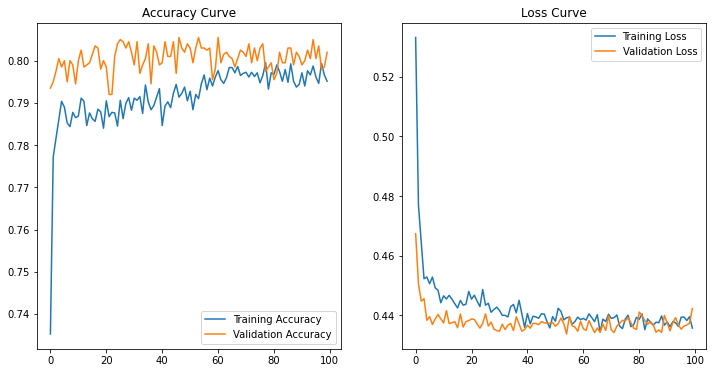

In [63]:
# Plotting the Accuracy and Loss Curves
plt.figure(figsize = (12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy Curve')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Loss Curve')
plt.legend()

plt.show()

In [64]:
# Predict the labels for the test set
y_pred = (cnn_model.predict(X_test_cnn) > 0.5).astype("int32")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

63/63 [==============================] - 0s 2ms/step


<Figure size 864x648 with 0 Axes>

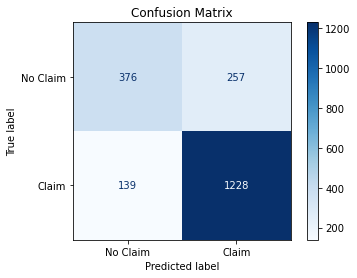

In [65]:
# Plot confusion matrix
plt.figure(figsize=(12, 9))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Claim', 'Claim']).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

- True Positives: 1,228
- True Negatives: 376
- False Positives: 257
- False Negatives: 139

# Conclusion

- The exploratory data analysis (EDA) revealed that lower-income individuals are more likely to file insurance claims, while the upper class has fewer claims.

- Individuals with over 30 years of driving experience tend to have fewer accidents and traffic violations, leading to fewer insurance claims.

- Car owners who purchased their vehicles after 2015 are less likely to file claims.

- In the model development phase, we implemented models like ANN and CNN, achieving an average accuracy of 80%. Improvements could be made by increasing data, balancing the dataset, and applying techniques like early stopping and learning rate adjustments.